## Лабораторная работа №1: Поэлементные преобразования изображений

Вариант: №2

Выполнил: Гершевский Егор

Группа: 6131-010402D

## Задание на лабораторную работу:

1. Считать цветное rgb изображение

2. Преобразовать изображение в градации серого

3. Написать функцию реализации препарирования изображения

4. По гистограмме изображения определить значение порога яркостей, обеспечивающего оптимальное разделение объекта и фона. Осуществить пороговую обработку входного изображения с найденным пороговым значением

5. Сделать пороговую обработку методом Otsu (Функция OpenCV)

6. Определить динамический диапазон входного изображения. Осуществить линейное контрастирование входного изображения в заданный динамический диапазон яркостей

7. Сделать эквализацию гистограммы изображения

8. Сделать эквализацию методом CLAHE (Функция OpenCV)

9. Осуществить препарирование изображения с заданной препарирующей функцией

In [1]:
from warnings import filterwarnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import *

filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

## Функции, которые необходимы для выполнения лабораторной работы

In [2]:
def show_image(image):
    """Функция для вывода изображения."""
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) if len(
        image.shape) == 3 else plt.imshow(image, cmap='gray')

In [3]:
def grayscale_image(image):
    """Функция для преобразования в градации серого."""
    return (np.dot(image[..., :3], np.array([0.2126, 0.7152, 0.0722]))).astype(np.uint8)

In [4]:
def threshold_processing(grayscale_image, threshold):
    """Функция пороговой обработки."""
    return np.vectorize(lambda x: 255 if x > threshold else 0)(grayscale_image)

In [5]:
def linear_contrast(grayscale_image):
    """Функция линейного контрастирования."""
    results = {
        'original_range': None,
        'original_image': None,
        'a': None,
        'b': None,
        'result_range': None,
        'result_image': None
    }

    x_min, x_max = grayscale_image.flatten().min(), grayscale_image.flatten().max()
    y_min, y_max = 0, 255
    a, b = (y_max - y_min) / (x_max - x_min), (y_min *
                                               x_max - y_max * x_min) / (x_max - x_min)

    result_image = (np.vectorize(lambda x: a * x + b)
                    (grayscale_image)).astype(np.uint8)

    results['original_range'] = (x_min, x_max)
    results['original_image'] = grayscale_image.copy()
    results['a'], results['b'] = a, b
    results['result_range'] = (
        result_image.flatten().min(), result_image.flatten().max())
    results['result_image'] = result_image.copy()

    return results

In [6]:
def equalization(grayscale_image):
    """Функция эквализации гистограммы изображения."""
    n, m = grayscale_image.shape
    hist, bins = np.histogram(grayscale_image.flatten(), 256, [0, 256])
    cdf = hist.cumsum()

    return (((cdf - cdf[0]) * 255 / (n * m - 1)).astype(np.uint8))[grayscale_image]

In [7]:
def image_preparation(grayscale_image, dissection):
    """Функция препарирования изображения."""
    return (np.vectorize(dissection)(grayscale_image)).astype(np.uint8)

In [8]:
def rendering(img_grayscale, _bins=256, cdf_plot=False, plot_title=None):
    """Функция отрисовки графиков."""
    plt.figure(figsize=(10, 5))
    plt.xlim([0, 256])

    if plot_title:
        title(plot_title)

    hist, bins = np.histogram(img_grayscale.flatten(), _bins, [0, 256])
    cdf = hist.cumsum() * float(hist.max()) / (hist.cumsum()).max()

    if cdf_plot:
        plt.plot(cdf, color='blue')
        plt.hist(img_grayscale.flatten(), _bins, [0, 256], color='red')
        plt.legend(('Функция распределения', 'Гистограмма'), loc='upper right')
    else:
        plt.hist(img_grayscale.flatten(), bins=_bins,
                 density=True, color='blue')

    plt.grid(True)
    plt.show()

## Задание 1. Считать цветное rgb изображение.

In [9]:
image = cv2.imread('../images/po.jpg')

Исходное изображение:


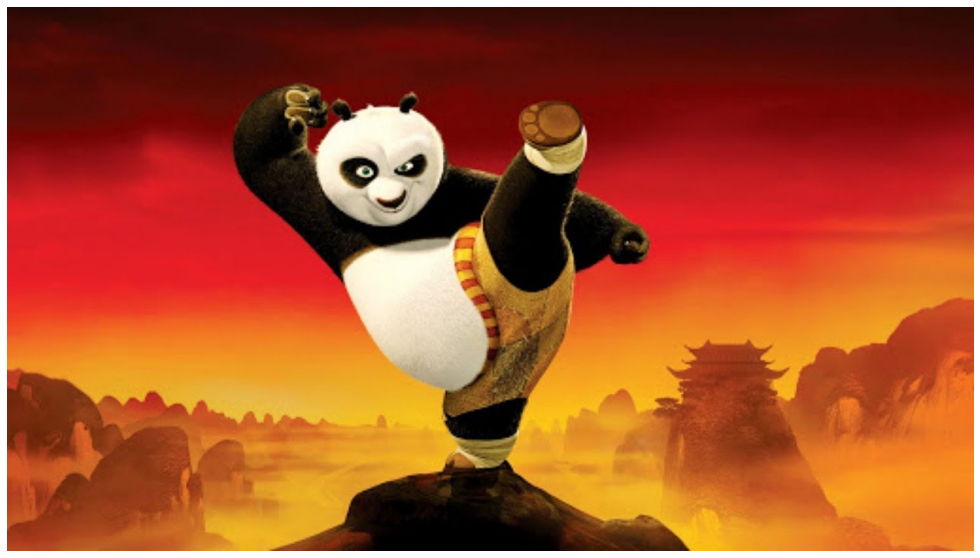

In [10]:
print('Исходное изображение:')
show_image(image)

## Задание 2. Преобразовать изображение в градации серого

Преобразованное изображение в градации серого:


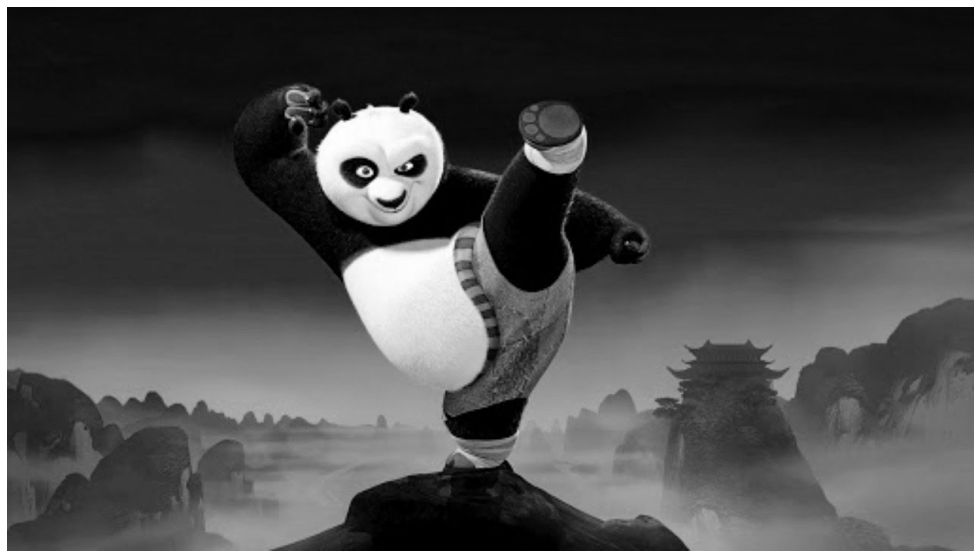

In [11]:
print('Преобразованное изображение в градации серого:')
gray_img = grayscale_image(image)
show_image(gray_img)

## Задание 3. Написать функцию реализации препарирования изображения

В данном варианте функция препарирования представляет собой яркостный срез с сохранением фона:

In [12]:
def dissection(x, a=150, y=110):
    """Функция препарирования."""
    if x > y and x < a:
        x = 255
    elif x >= a:
        x = (x)
    else:
        x = x * 0.85
    if x > 255:
        x = 255
    return x

## Задание 4. По гистограмме изображения определить значение порога яркостей, обеспечивающего оптимальное разделение объекта и фона. Осуществить пороговую обработку входного изображения с найденным пороговым значением

Исходное изображение:


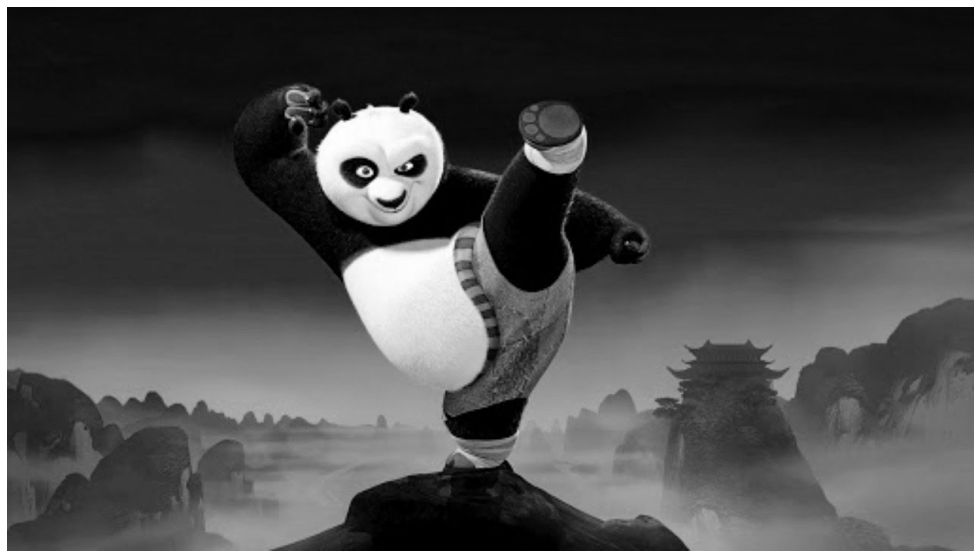

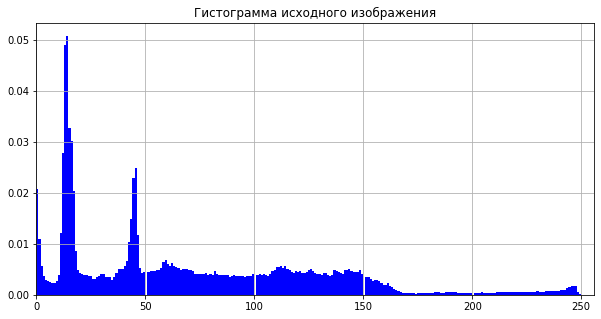

In [13]:
print('Исходное изображение:')
show_image(gray_img)
rendering(gray_img, plot_title='Гистограмма исходного изображения')

Изображение после пороговой обработки:


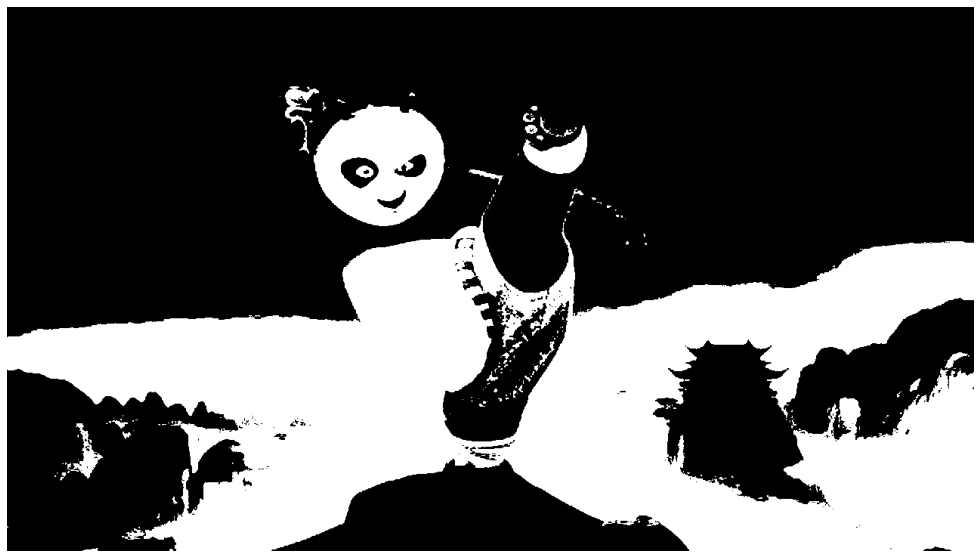

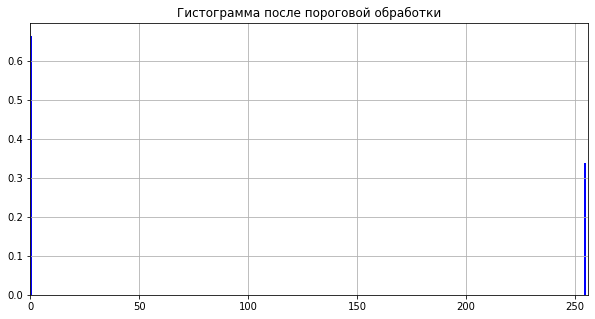

In [14]:
print('Изображение после пороговой обработки:')
img_threshold = threshold_processing(gray_img, 90)
show_image(img_threshold)
rendering(img_threshold, plot_title='Гистограмма после пороговой обработки')

## Задание 5. Сделать пороговую обработку методом `Otsu` (Функция OpenCV)

Метод `Otsu` основан на минимизации внутриклассовой дисперсии:

$$ \sigma_{w}^2 (t) = w_0 (t) \sigma_0^2 (t) + w_1 (t) \sigma_1^2 (t) \rightarrow min ,$$

*где* $t$ - *пороговое значение*, $ w_0 (t) $ *и* $ w_1 (t) $ - *это сумма вероятностей внутри классов, разделенных пороговым значением* $ t $, $ \sigma_0^2 (t) $ *и* $ \sigma_1^2 (t) $ - *внутриклассовые дисперсии*

In [15]:
opencv_threshold, opencv_threshold_image = cv2.threshold(gray_img, 0, 255, cv2.THRESH_OTSU)

Пороговая обработка методом Otsu изображения:


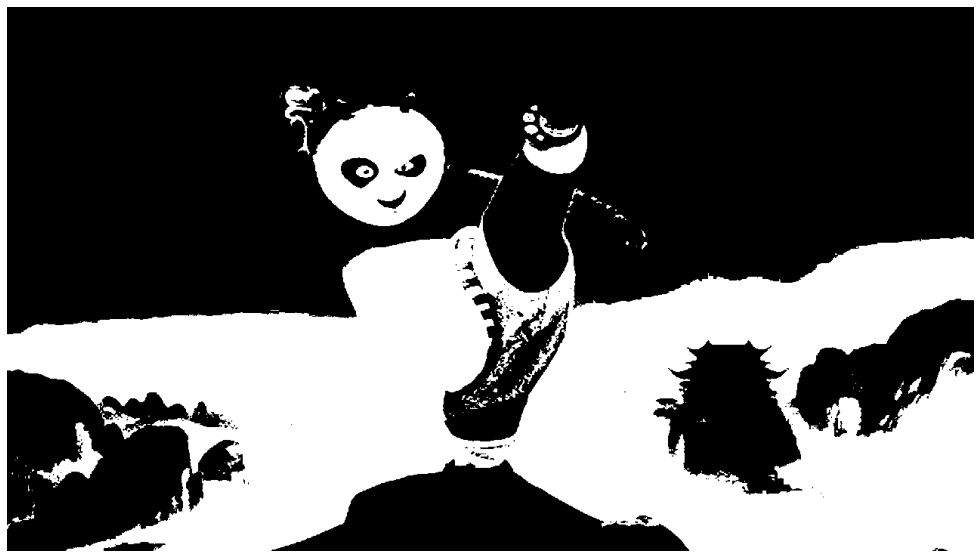

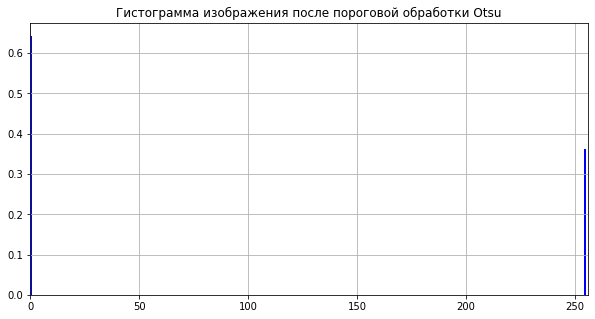

In [16]:
print('Пороговая обработка методом Otsu изображения:')
show_image(opencv_threshold_image)
rendering(opencv_threshold_image,
          plot_title='Гистограмма изображения после пороговой обработки Otsu')

## Задание 6. Определить динамический диапазон входного изображения. Осуществить линейное контрастирование входного изображения в заданный динамический диапазон яркостей

In [17]:
gaben = cv2.imread('../images/Gaben.png')
gaben_grayscale = grayscale_image(gaben)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


In [18]:
linear_contrast_results = linear_contrast(gaben_grayscale)
print(
    f"Линейное преобразование для данного изображения: y = {linear_contrast_results['a']} * x + {linear_contrast_results['b']}")

Линейное преобразование для данного изображения: y = 2.8333333333333335 * x + -263.5


Динамический диапазон исходного изображения: (93, 183)


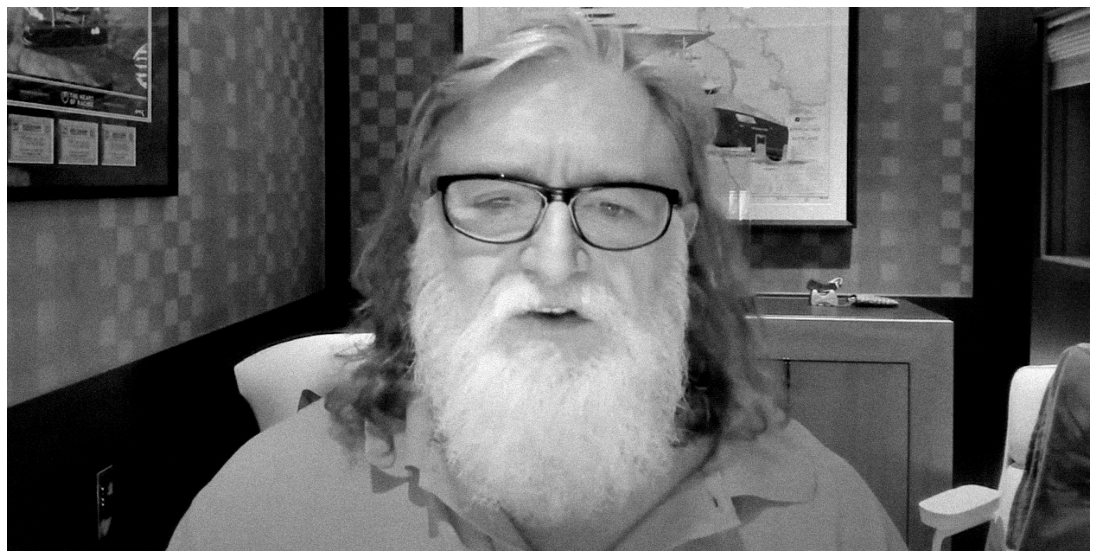

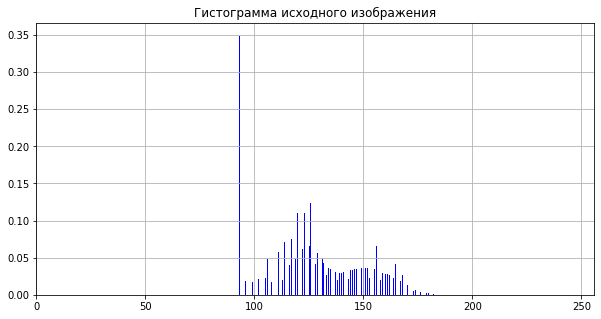

In [19]:
print(
    f"Динамический диапазон исходного изображения: {linear_contrast_results['original_range']}")
show_image(linear_contrast_results['original_image'])
rendering(linear_contrast_results['original_image'],
          plot_title='Гистограмма исходного изображения')

Динамический диапазон после линейного контрастирования: (0, 255)


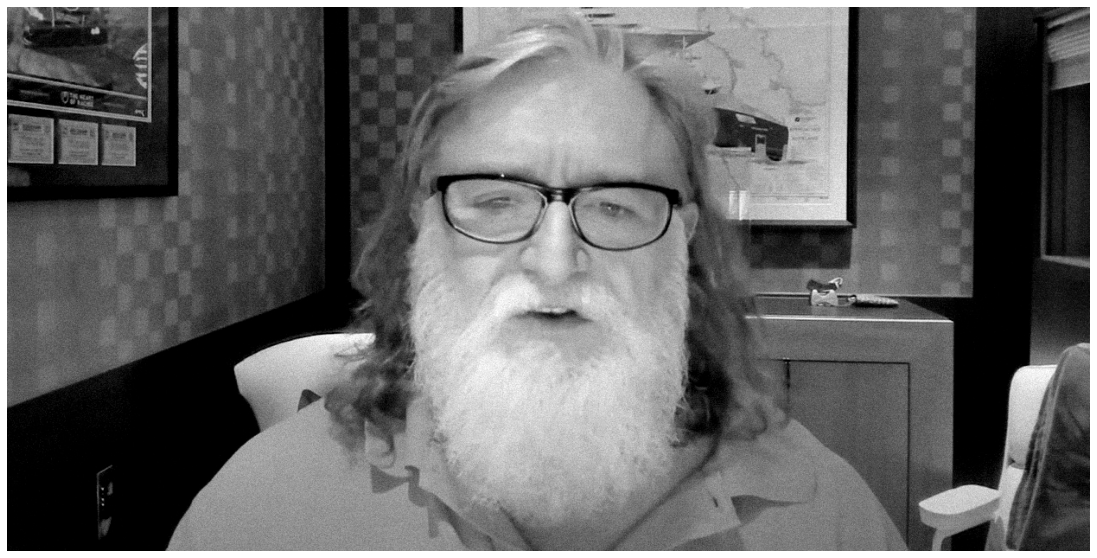

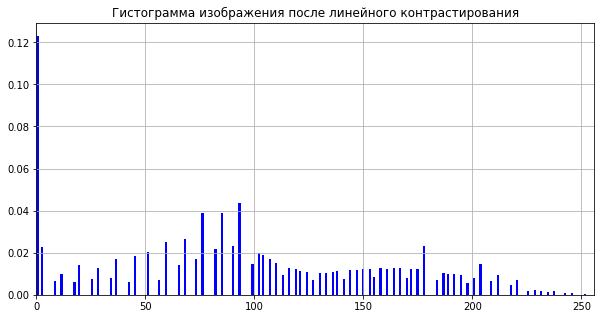

In [20]:
print(
    f"Динамический диапазон после линейного контрастирования: {linear_contrast_results['result_range']}")
show_image(linear_contrast_results['result_image'])
rendering(linear_contrast_results['result_image'],
          plot_title='Гистограмма изображения после линейного контрастирования')

## Задание 7. Сделать эквализацию гистограммы изображения

* *__Вход:__ изображение из пункта 2*
* *__Вывод:__ входное и результирующие изображение и их гистограммы соответственно*

Исходное изображение:


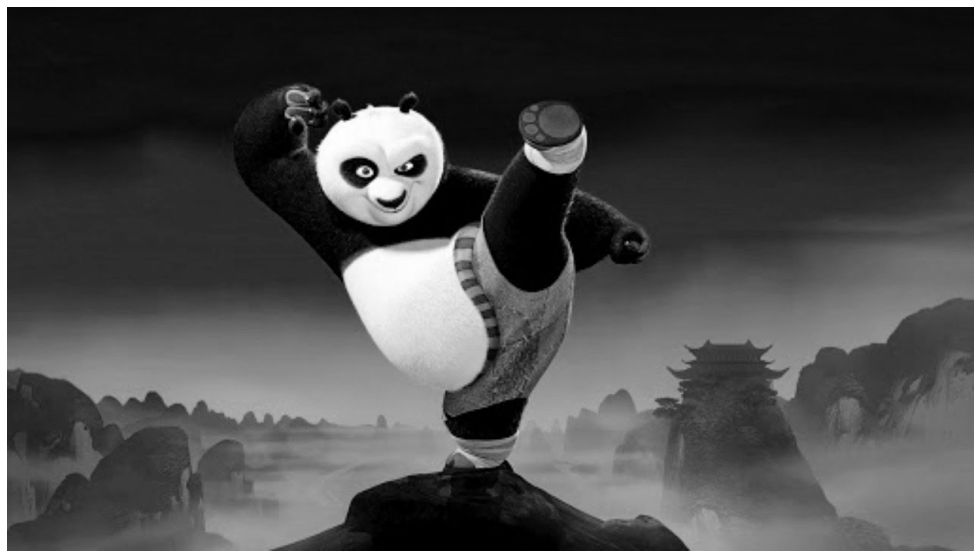

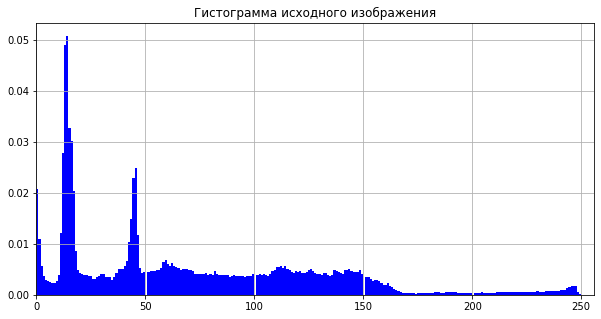

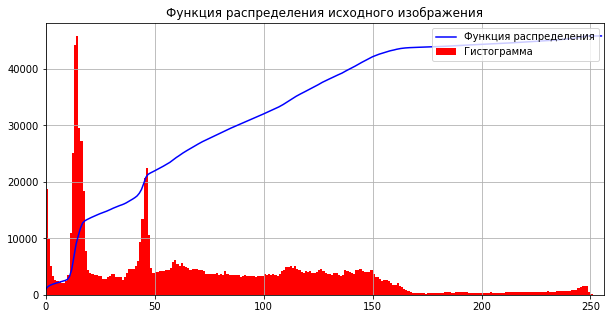

In [21]:
print('Исходное изображение:')
show_image(gray_img)
rendering(gray_img, plot_title='Гистограмма исходного изображения')
rendering(
    gray_img, plot_title='Функция распределения исходного изображения', cdf_plot=True)

Эквализированное изображение:


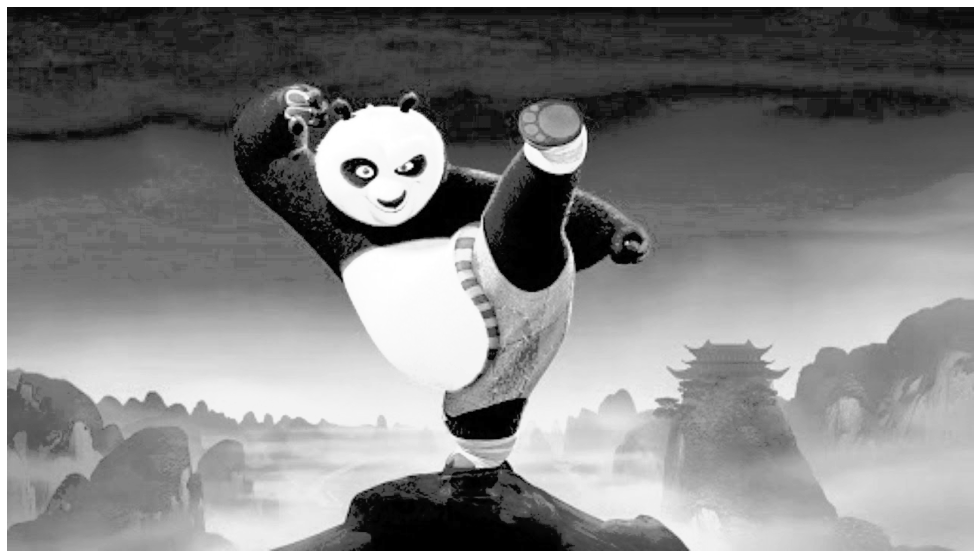

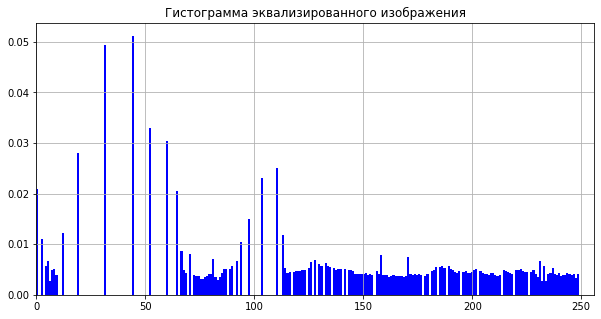

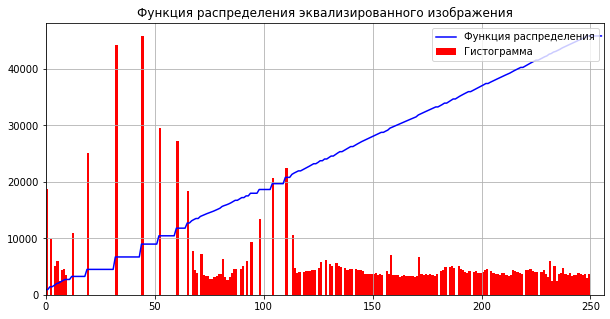

In [22]:
print('Эквализированное изображение:')
image_equal = equalization(gray_img)
show_image(image_equal)
rendering(image_equal, plot_title='Гистограмма эквализированного изображения')
rendering(image_equal,
          plot_title='Функция распределения эквализированного изображения', cdf_plot=True)

## Задание 8. Сделать эквализацию методом `CLAHE` (Функция OpenCV)

In [23]:
opencv_image_equal = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(gray_img)

Эквализированное изображение по CLAHE:


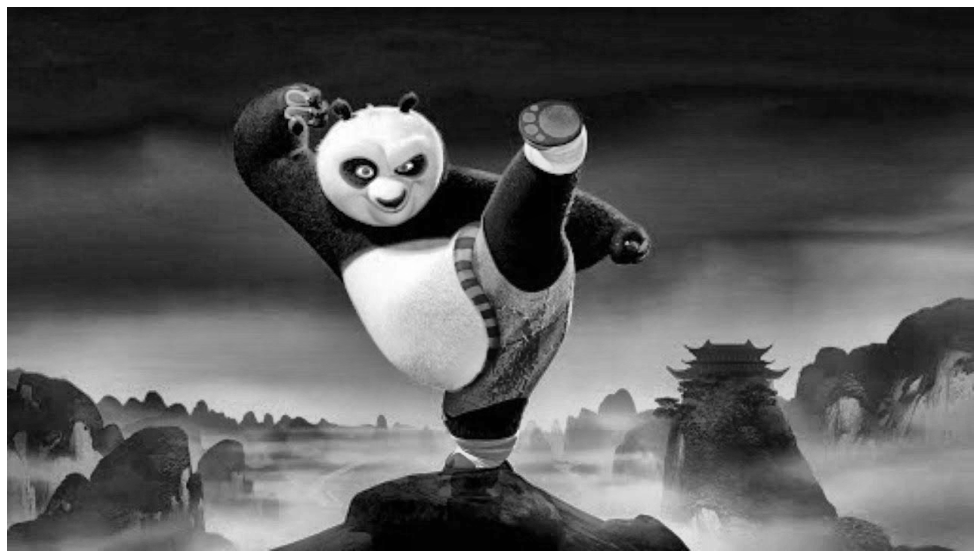

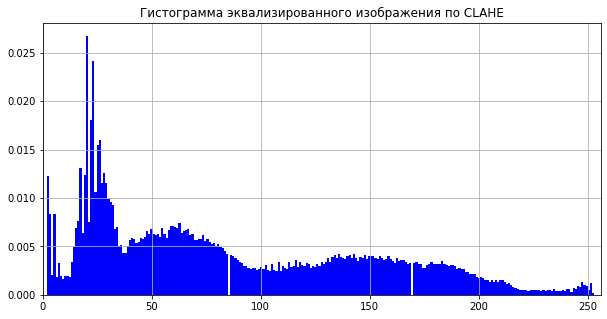

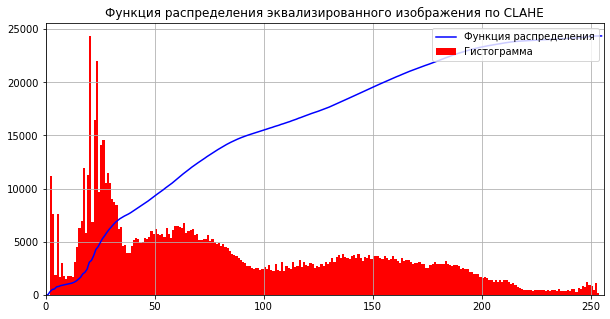

In [24]:
print('Эквализированное изображение по CLAHE:')
show_image(opencv_image_equal)
rendering(opencv_image_equal,
          plot_title='Гистограмма эквализированного изображения по CLAHE')
rendering(opencv_image_equal,
          plot_title='Функция распределения эквализированного изображения по CLAHE', cdf_plot=True)

## Задание 9. Осуществить препарирование изображения с заданной препарирующей функцией

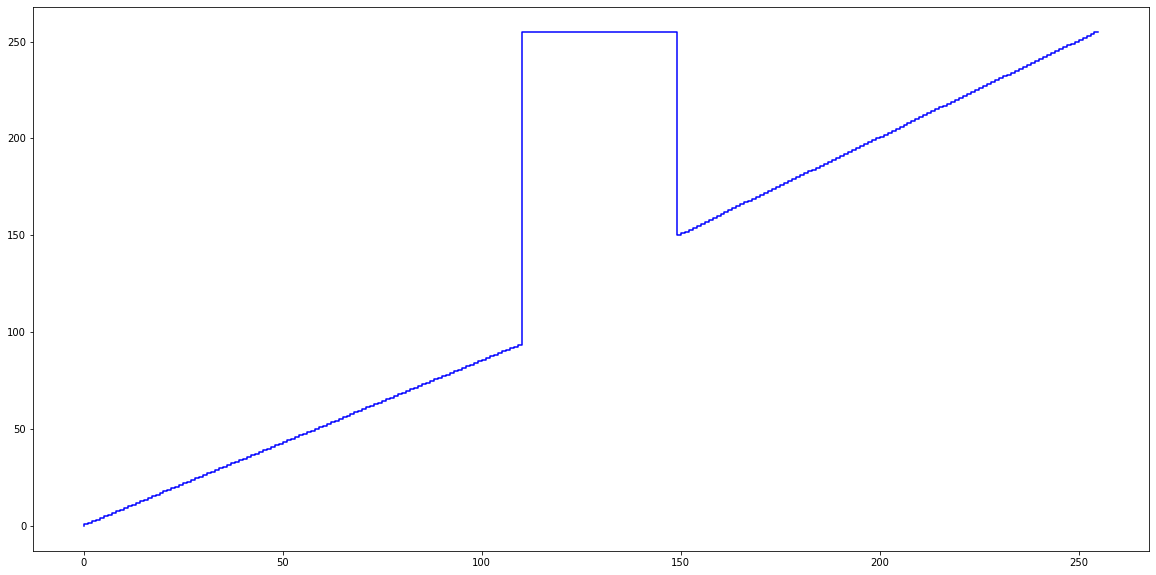

In [25]:
plt.step(range(0, 256), [dissection(x) for x in range(0, 256)], c='blue')

Исходное изображение:


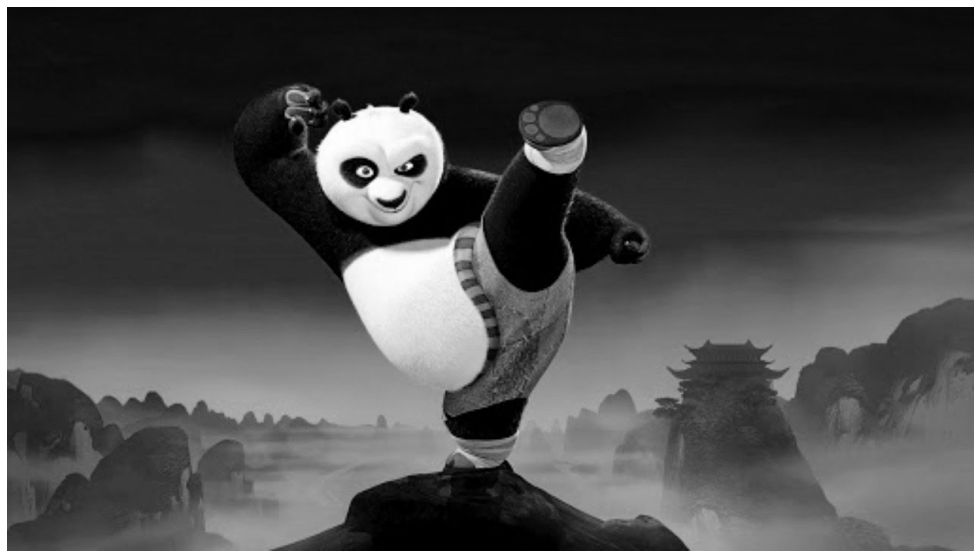

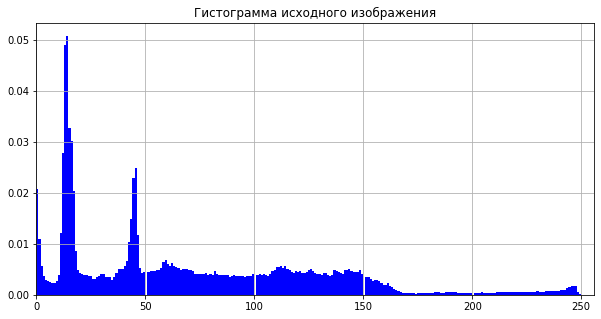

In [26]:
print('Исходное изображение:')
show_image(gray_img)
rendering(gray_img, plot_title='Гистограмма исходного изображения')

Препарированное изображение:


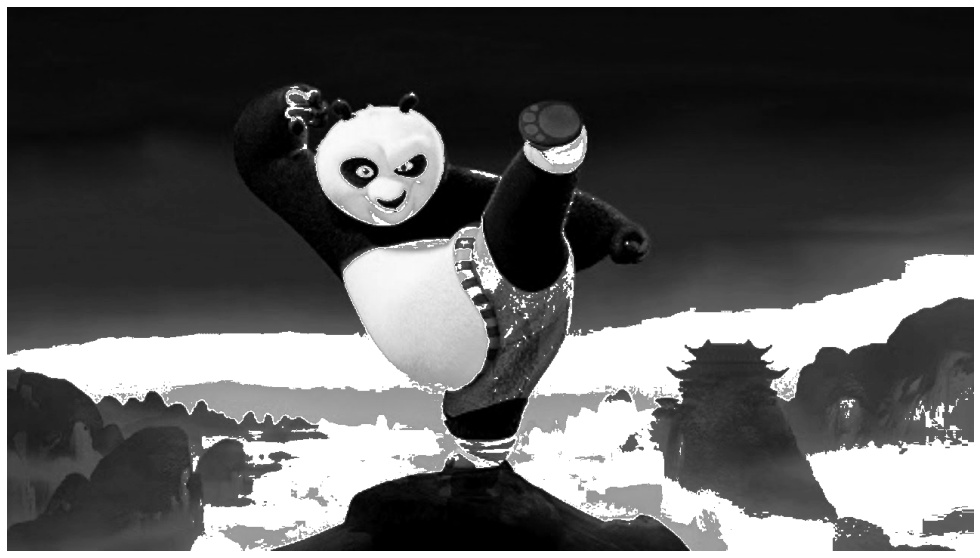

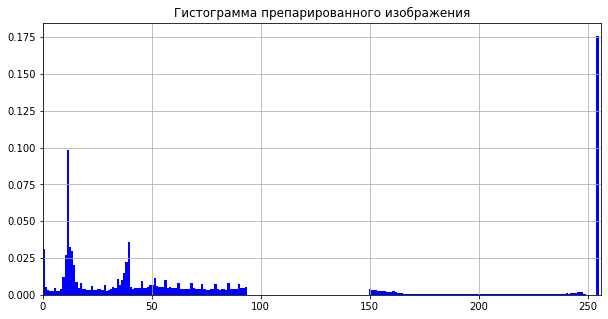

In [27]:
print('Препарированное изображение:')
prep_image = image_preparation(gray_img, dissection)
show_image(prep_image)
rendering(prep_image, plot_title='Гистограмма препарированного изображения')